In [1]:
from typing import Any, Tuple, Mapping, Callable, List, Dict
from functools import partial
from flax.metrics import tensorboard
import orbax
import orbax.checkpoint
import flax.jax_utils
from flaxdiff.models.simple_unet import Unet
import jax.experimental.pallas.ops.tpu.flash_attention
from flaxdiff.predictors import VPredictionTransform, EpsilonPredictionTransform, DiffusionPredictionTransform, DirectPredictionTransform, KarrasPredictionTransform
from flaxdiff.schedulers import CosineNoiseSchedule, NoiseScheduler, GeneralizedNoiseScheduler, KarrasVENoiseScheduler, EDMNoiseScheduler
import struct as st
import flax
import tqdm
from flax import linen as nn
import jax
from typing import Dict, Callable, Sequence, Any, Union
from dataclasses import field
import jax.numpy as jnp
import grain.python as pygrain
import numpy as np
import augmax

import matplotlib.pyplot as plt
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from flax import struct                # Flax dataclasses
import time
import os
from datetime import datetime
from flax.training import orbax_utils
import functools

import json
# For CLIP
from transformers import AutoTokenizer, FlaxCLIPTextModel, CLIPTextModel
import wandb
import cv2
import argparse

import resource

from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental import mesh_utils
from jax.experimental.shard_map import shard_map

2024-08-06 12:24:02.855639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 12:24:02.876634: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 12:24:02.883086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 12:24:03.792118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mrwhite0racle/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tq

In [2]:
normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(jnp.astype(denormalizeImage(imgs[i, :, :, :]), jnp.uint8))
        plt.axis("off")
    plt.show()

In [3]:
class MarkovState(struct.PyTreeNode):
    pass


class RandomMarkovState(MarkovState):
    rng: jax.random.PRNGKey

    def get_random_key(self):
        rng, subkey = jax.random.split(self.rng)
        return RandomMarkovState(rng), subkey
    
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

# Define the TrainState
class SimpleTrainState(train_state.TrainState):
    metrics: Metrics

class SimpleTrainer:
    state: SimpleTrainState
    best_state: SimpleTrainState
    best_loss: float
    model: nn.Module
    ema_decay: float = 0.999

    def __init__(self,
                 model: nn.Module,
                 input_shapes: Dict[str, Tuple[int]],
                 optimizer: optax.GradientTransformation,
                 rngs: jax.random.PRNGKey,
                 train_state: SimpleTrainState = None,
                 name: str = "Simple",
                 load_from_checkpoint: bool = False,
                 checkpoint_suffix: str = "",
                 checkpoint_id: str = None,
                 loss_fn=optax.l2_loss,
                 param_transforms: Callable = None,
                 wandb_config: Dict[str, Any] = None,
                 distributed_training: bool = None,
                 checkpoint_base_path: str = "./checkpoints",
                 ):
        if distributed_training is None or distributed_training is True:
            # Auto-detect if we are running on multiple devices
            distributed_training = jax.device_count() > 1
            self.mesh = jax.sharding.Mesh(jax.devices(), 'data')
            # self.sharding = jax.sharding.NamedSharding(self.mesh, jax.sharding.PartitionSpec('data'))

        self.distributed_training = distributed_training
        self.model = model
        self.name = name
        self.loss_fn = loss_fn
        self.input_shapes = input_shapes
        self.checkpoint_base_path = checkpoint_base_path
        
        
        if wandb_config is not None and jax.process_index() == 0:
            run = wandb.init(**wandb_config)
            self.wandb = run
            
            # define our custom x axis metric
            self.wandb.define_metric("train/step")
            self.wandb.define_metric("train/epoch")
            
            self.wandb.define_metric("train/loss", step_metric="train/step")
            
            self.wandb.define_metric("train/epoch_time", step_metric="train/epoch")
            self.wandb.define_metric("train/avg_time_per_step", step_metric="train/epoch")
            self.wandb.define_metric("train/avg_loss", step_metric="train/epoch")
            self.wandb.define_metric("train/best_loss", step_metric="train/epoch")

        if checkpoint_id is None:
            self.checkpoint_id = name.replace(' ', '_').replace('-', '_').lower()
        else:
            self.checkpoint_id = checkpoint_id
            
        # checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        async_checkpointer = orbax.checkpoint.AsyncCheckpointer(orbax.checkpoint.PyTreeCheckpointHandler(), timeout_secs=60)

        options = orbax.checkpoint.CheckpointManagerOptions(
            max_to_keep=4, create=True)
        self.checkpointer = orbax.checkpoint.CheckpointManager(
            self.checkpoint_path() + checkpoint_suffix, async_checkpointer, options)

        if load_from_checkpoint:
            latest_epoch, old_state, old_best_state, rngstate = self.load()
        else:
            latest_epoch, old_state, old_best_state, rngstate = 0, None, None, None

        self.latest_epoch = latest_epoch
        
        if rngstate:
            self.rngstate = RandomMarkovState(**rngstate)
        else:
            self.rngstate = RandomMarkovState(rngs)
            
        self.rngstate, subkey = self.rngstate.get_random_key()

        if train_state == None:
            state, best_state = self.generate_states(
                optimizer, subkey, old_state, old_best_state, model, param_transforms
            )
            self.init_state(state, best_state)
        else:
            self.state = train_state
            self.best_state = train_state
            self.best_loss = 1e9

    def get_input_ones(self):
        return {k: jnp.ones((1, *v)) for k, v in self.input_shapes.items()}

    def generate_states(
        self,
        optimizer: optax.GradientTransformation,
        rngs: jax.random.PRNGKey,
        existing_state: dict = None,
        existing_best_state: dict = None,
        model: nn.Module = None,
        param_transforms: Callable = None
    ) -> Tuple[SimpleTrainState, SimpleTrainState]:
        print("Generating states for SimpleTrainer")
        rngs, subkey = jax.random.split(rngs)

        if existing_state == None:
            input_vars = self.get_input_ones()
            params = model.init(subkey, **input_vars)
        else:
            params = existing_state['params']

        state = SimpleTrainState.create(
            apply_fn=model.apply,
            params=params,
            tx=optimizer,
            metrics=Metrics.empty()
        )
        if existing_best_state is not None:
            best_state = state.replace(
                params=existing_best_state['params'])
        else:
            best_state = state
            
        return state, best_state

    def init_state(
        self,
        state: SimpleTrainState,
        best_state: SimpleTrainState,
    ):
        self.best_loss = 1e9

        self.state = state
        self.best_state = best_state

    def get_state(self):
        # return fully_replicated_host_local_array_to_global_array()
        return jax.tree_util.tree_map(lambda x : np.array(x), self.state)

    def get_best_state(self):
        # return convert_to_global_tree(self.mesh, flax.jax_utils.replicate(self.best_state, jax.local_devices()))
        return jax.tree_util.tree_map(lambda x : np.array(x), self.best_state)
        
    def get_rngstate(self):
        # return convert_to_global_tree(self.mesh, flax.jax_utils.replicate(self.rngstate, jax.local_devices()))
        return jax.tree_util.tree_map(lambda x : np.array(x), self.rngstate)

    def checkpoint_path(self):
        path = os.path.join(self.checkpoint_base_path, self.checkpoint_id)
        if not os.path.exists(path):
            os.makedirs(path)
        return path

    def tensorboard_path(self):
        experiment_name = self.name
        path = os.path.join(os.path.abspath('./tensorboard'), experiment_name)
        if not os.path.exists(path):
            os.makedirs(path)
        return path

    def load(self):
        epoch = self.checkpointer.latest_step()
        print("Loading model from checkpoint", epoch)
        ckpt = self.checkpointer.restore(epoch)
        state = ckpt['state']
        best_state = ckpt['best_state']
        rngstate = ckpt['rngs']
        # Convert the state to a TrainState
        self.best_loss = ckpt['best_loss']
        print(
            f"Loaded model from checkpoint at epoch {epoch}", ckpt['best_loss'])
        return epoch, state, best_state, rngstate

    def save(self, epoch=0):
        print(f"Saving model at epoch {epoch}")
        ckpt = {
            # 'model': self.model,
            'rngs': self.get_rngstate(),
            'state': self.get_state(),
            'best_state': self.get_best_state(),
            'best_loss': np.array(self.best_loss),
        }
        try:
            save_args = orbax_utils.save_args_from_target(ckpt)
            self.checkpointer.save(epoch, ckpt, save_kwargs={
                                   'save_args': save_args}, force=True)
            self.checkpointer.wait_until_finished()
            pass
        except Exception as e:
            print("Error saving checkpoint", e)

    def _define_train_step(self, **kwargs):
        model = self.model
        loss_fn = self.loss_fn
        distributed_training = self.distributed_training

        def train_step(train_state: SimpleTrainState, rng_state: RandomMarkovState, batch, local_device_indexes):
            """Train for a single step."""
            images = batch['image']
            labels = batch['label']

            def model_loss(params):
                preds = model.apply(params, images)
                expected_output = labels
                nloss = loss_fn(preds, expected_output)
                loss = jnp.mean(nloss)
                return loss
            loss, grads = jax.value_and_grad(model_loss)(train_state.params)
            if distributed_training:
                grads = jax.lax.pmean(grads, "data")
            train_state = train_state.apply_gradients(grads=grads)
            return train_state, loss, rng_state
        
        if distributed_training:
            train_step = shard_map(train_step, mesh=self.mesh, in_specs=(P(), P(), P('data'), P('data')), out_specs=(P(), P('data'), P()))
            train_step = jax.pmap(train_step)
        return train_step

    def _define_compute_metrics(self):
        model = self.model
        loss_fn = self.loss_fn

        @jax.jit
        def compute_metrics(state: SimpleTrainState, batch):
            preds = model.apply(state.params, batch['image'])
            expected_output = batch['label']
            loss = jnp.mean(loss_fn(preds, expected_output))
            metric_updates = state.metrics.single_from_model_output(
                loss=loss, logits=preds, labels=expected_output)
            metrics = state.metrics.merge(metric_updates)
            state = state.replace(metrics=metrics)
            return state
        return compute_metrics

    def summary(self):
        input_vars = self.get_input_ones()
        print(self.model.tabulate(jax.random.key(0), **input_vars,
              console_kwargs={"width": 200, "force_jupyter": True, }))

    def config(self):
        return {
            "model": self.model,
            "state": self.state,
            "name": self.name,
            "input_shapes": self.input_shapes
        }

    def init_tensorboard(self, batch_size, steps_per_epoch, epochs):
        from flax.metrics import tensorboard
        summary_writer = tensorboard.SummaryWriter(self.tensorboard_path())
        summary_writer.hparams({
            **self.config(),
            "steps_per_epoch": steps_per_epoch,
            "epochs": epochs,
            "batch_size": batch_size
        })
        return summary_writer

    def fit(self, data, steps_per_epoch, epochs, train_step_args={}):
        train_ds = iter(data['train']())
        if 'test' in data:
            test_ds = data['test']
        else:
            test_ds = None
        train_step = self._define_train_step(**train_step_args)
        compute_metrics = self._define_compute_metrics()
        train_state = self.state
        rng_state = self.rngstate
        global_device_count = jax.device_count()
        local_device_count = jax.local_device_count()
        process_index = jax.process_index()
        if self.distributed_training:
            global_device_indexes = jnp.arange(global_device_count)
        else:
            global_device_indexes = 0

        def train_loop(current_epoch, pbar: tqdm.tqdm, train_state, rng_state):
            epoch_loss = 0
            current_step = 0
            for i in range(steps_per_epoch):
                batch = next(train_ds)
                if self.distributed_training and global_device_count > 1:
                    # Convert the local device batches to a unified global jax.Array 
                    batch = convert_to_global_tree(self.mesh, batch)
                train_state, loss, rng_state = train_step(train_state, rng_state, batch, global_device_indexes)

                if self.distributed_training:
                    loss = jax.experimental.multihost_utils.process_allgather(loss)
                    loss = jnp.mean(loss) # Just to make sure its a scaler value
                            
                epoch_loss += loss
                    
                if pbar is not None:
                    if i % 100 == 0:
                        pbar.set_postfix(loss=f'{loss:.4f}')
                        pbar.update(100)
                        current_step = current_epoch*steps_per_epoch + i
                        if self.wandb is not None:
                            self.wandb.log({
                                "train/step" : current_step,
                                "train/loss": loss,
                            }, step=current_step)
            print(colored(f"Epoch done on index {process_index} => {current_epoch} Loss: {epoch_loss/steps_per_epoch}", 'green'))
            return epoch_loss, current_step, train_state, rng_state

        while self.latest_epoch < epochs:
            current_epoch = self.latest_epoch
            self.latest_epoch += 1
            print(f"\nEpoch {current_epoch}/{epochs}")
            start_time = time.time()
            epoch_loss = 0

            if process_index == 0:
                with tqdm.tqdm(total=steps_per_epoch, desc=f'\t\tEpoch {current_epoch}', ncols=100, unit='step') as pbar:
                    epoch_loss, current_step, train_state, rng_state = train_loop(current_epoch, pbar, train_state, rng_state)
            else:
                epoch_loss, current_step, train_state, rng_state = train_loop(current_epoch, None, train_state, rng_state)
                print(colored(f"Epoch done on process index {process_index}", PROCESS_COLOR_MAP[process_index]))
                
            end_time = time.time()
            self.state = train_state
            self.rngstate = rng_state
            total_time = end_time - start_time
            avg_time_per_step = total_time / steps_per_epoch
            avg_loss = epoch_loss / steps_per_epoch
            if avg_loss < self.best_loss:
                self.best_loss = avg_loss
                self.best_state = train_state
                self.save(current_epoch)
                
            if process_index == 0:
                if self.wandb is not None:
                    self.wandb.log({
                        "train/epoch_time": total_time,
                        "train/avg_time_per_step": avg_time_per_step,
                        "train/avg_loss": avg_loss,
                        "train/best_loss": self.best_loss,
                        "train/epoch": current_epoch,
                    }, step=current_step)
                print(colored(f"\n\tEpoch {current_epoch} completed. Avg Loss: {avg_loss}, Time: {total_time:.2f}s, Best Loss: {self.best_loss}", 'green'))
        self.save(epochs)
        return self.state
# Define the TrainState with EMA parameters

class TrainState(SimpleTrainState):
    rngs: jax.random.PRNGKey
    ema_params: dict

    def apply_ema(self, decay: float = 0.999):
        new_ema_params = jax.tree_util.tree_map(
            lambda ema, param: decay * ema + (1 - decay) * param,
            self.ema_params,
            self.params,
        )
        return self.replace(ema_params=new_ema_params)


class DiffusionTrainer(SimpleTrainer):
    noise_schedule: NoiseScheduler
    model_output_transform: DiffusionPredictionTransform
    ema_decay: float = 0.999

    def __init__(self,
                 model: nn.Module,
                 input_shapes: Dict[str, Tuple[int]],
                 optimizer: optax.GradientTransformation,
                 noise_schedule: NoiseScheduler,
                 rngs: jax.random.PRNGKey,
                 unconditional_prob: float = 0.2,
                 name: str = "Diffusion",
                 model_output_transform: DiffusionPredictionTransform = EpsilonPredictionTransform(),
                 **kwargs
                 ):
        super().__init__(
            model=model,
            input_shapes=input_shapes,
            optimizer=optimizer,
            rngs=rngs,
            name=name,
            **kwargs
        )
        self.noise_schedule = noise_schedule
        self.model_output_transform = model_output_transform
        self.unconditional_prob = unconditional_prob

    def generate_states(
        self,
        optimizer: optax.GradientTransformation,
        rngs: jax.random.PRNGKey,
        existing_state: dict = None,
        existing_best_state: dict = None,
        model: nn.Module = None,
        param_transforms: Callable = None
    ) -> Tuple[TrainState, TrainState]:
        print("Generating states for DiffusionTrainer")
        rngs, subkey = jax.random.split(rngs)

        if existing_state == None:
            input_vars = self.get_input_ones()
            params = model.init(subkey, **input_vars)
            new_state = {"params": params, "ema_params": params}
        else:
            new_state = existing_state

        if param_transforms is not None:
            params = param_transforms(params)

        state = TrainState.create(
            apply_fn=model.apply,
            params=new_state['params'],
            ema_params=new_state['ema_params'],
            tx=optimizer,
            rngs=rngs,
            metrics=Metrics.empty()
        )
            
        if existing_best_state is not None:
            best_state = state.replace(
                params=existing_best_state['params'], ema_params=existing_best_state['ema_params'])
        else:
            best_state = state

        return state, best_state

    def _define_train_step(self, batch_size, null_labels_seq, text_embedder):
        noise_schedule = self.noise_schedule
        model = self.model
        model_output_transform = self.model_output_transform
        loss_fn = self.loss_fn
        unconditional_prob = self.unconditional_prob

        # Determine the number of unconditional samples
        num_unconditional = int(batch_size * unconditional_prob)

        nS, nC = null_labels_seq.shape
        null_labels_seq = jnp.broadcast_to(
            null_labels_seq, (batch_size, nS, nC))

        distributed_training = self.distributed_training

        # @jax.jit
        def train_step(train_state: TrainState, batch, rng_state: RandomMarkovState, local_device_index):
            """Train for a single step."""
            images = batch['image']
            # normalize image
            images = (images - 127.5) / 127.5

            output = text_embedder(
                input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            label_seq = output.last_hidden_state

            # Generate random probabilities to decide how much of this batch will be unconditional

            label_seq = jnp.concat(
                [null_labels_seq[:num_unconditional], label_seq[num_unconditional:]], axis=0)

            rng_state, subkey = rng_state.get_random_key()
            subkey = jax.random.fold_in(subkey, local_device_index)
            subkey = jax.random.fold_in(subkey, jax.process_index())
            local_rng_state = RandomMarkovState(subkey)

            noise_level, local_rng_state = noise_schedule.generate_timesteps(images.shape[0], local_rng_state)
            
            local_rng_state, rngs = local_rng_state.get_random_key()
            noise: jax.Array = jax.random.normal(rngs, shape=images.shape)
            
            rates = noise_schedule.get_rates(noise_level)
            noisy_images, c_in, expected_output = model_output_transform.forward_diffusion(
                images, noise, rates)

            def model_loss(params):
                preds = model.apply(
                    params, *noise_schedule.transform_inputs(noisy_images*c_in, noise_level), label_seq)
                preds = model_output_transform.pred_transform(
                    noisy_images, preds, rates)
                nloss = loss_fn(preds, expected_output)
                # nloss = jnp.mean(nloss, axis=1)
                nloss *= noise_schedule.get_weights(noise_level)
                nloss = jnp.mean(nloss)
                loss = nloss
                return loss
            
            loss, grads = jax.value_and_grad(model_loss)(train_state.params)
            if distributed_training:
                grads = jax.lax.pmean(grads, "data")
            train_state = train_state.apply_gradients(grads=grads)
            train_state = train_state.apply_ema(self.ema_decay)
            return train_state, loss, rng_state
        
        if distributed_training:
            train_step = jax.pmap(train_step, axis_name="data")
            # train_step = shard_map(train_step, mesh=self.mesh, in_specs=P('data'), out_specs=P())
        else:
            train_step = jax.jit(train_step)
            
        return train_step

    def _define_compute_metrics(self):
        @jax.jit
        def compute_metrics(state: TrainState, expected, pred):
            loss = jnp.mean(jnp.square(pred - expected))
            metric_updates = state.metrics.single_from_model_output(loss=loss)
            metrics = state.metrics.merge(metric_updates)
            state = state.replace(metrics=metrics)
            return state
        return compute_metrics

    def fit(self, data, steps_per_epoch, epochs):
        null_labels_full = data['null_labels_full']
        local_batch_size = data['local_batch_size']
        text_embedder = data['model']
        super().fit(data, steps_per_epoch, epochs, {
            "batch_size": local_batch_size, "null_labels_seq": null_labels_full, "text_embedder": text_embedder})

def boolean_string(s):
    if type(s) == bool:
        return s
    return s == 'True'


In [17]:
CONFIG = {
    #   "dtype": "bfloat16",
    #   "precision": "high",
    #   "activation": "swish",
      "emb_features": 256,
      "feature_depths": [
        64,
        128,
        256,
        512
      ],
      "num_res_blocks": 3,
      "attention_configs": [
        None,
        {
          "dtype": jnp.bfloat16,
          "heads": 16,
          "use_projection": False,
          "flash_attention": False,
          "use_self_and_cross": False
        },
        {
          "dtype": jnp.bfloat16,
          "heads": 16,
          "use_projection": False,
          "flash_attention": False,
          "use_self_and_cross": False
        },
        {
          "dtype": jnp.bfloat16,
          "heads": 16,
          "use_projection": False,
          "flash_attention": False,
          "use_self_and_cross": False
        }
      ],
      "num_middle_res_blocks": 1
}

In [18]:

model_config = CONFIG
IMAGE_SIZE=128
# model_config['activation'] = ACTIVATION_MAP[model_config['activation']]
# model_config['dtype'] = DTYPE_MAP[model_config['dtype']]
# model_config['precision'] = PRECISION_MAP[model_config['precision']]
unet = Unet(activation=jax.nn.swish, dtype=jnp.bfloat16, precision=jax.lax.Precision.HIGH, **model_config)
solver = optax.adam(2e-4)

edm_schedule = EDMNoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)
karas_ve_schedule = KarrasVENoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)

trainer = DiffusionTrainer(unet, optimizer=solver, 
                           noise_schedule=edm_schedule,
                           rngs=jax.random.PRNGKey(4), 
                           name="batch 256 v4-32 host laiona_coco",
                           model_output_transform=KarrasPredictionTransform(sigma_data=edm_schedule.sigma_data),
                           input_shapes= {
                                "x": (128, 128, 3),
                                "temb": (),
                                "textcontext": (77, 768)
                            },
                        #    train_state=trainer.best_state,
                        #    loss_fn=lambda x, y: jnp.abs(x - y),
                            # param_transforms=params_transform,
                           load_from_checkpoint=True,
                           checkpoint_id="batch 256 v4-16 host laiona_coco",
                           checkpoint_base_path="gs://flaxdiff-datasets-regional/checkpoints/"
                           )

Loading model from checkpoint 3
Loaded model from checkpoint at epoch 3 0.050141703
Generating states for DiffusionTrainer


In [25]:
from flaxdiff.utils import clip_images

def clip_images(images, clip_min=-1, clip_max=1):
    return jnp.clip(images, clip_min, clip_max)
    
class DiffusionSampler():
    model:nn.Module
    noise_schedule:NoiseScheduler
    params:dict
    model_output_transform:DiffusionPredictionTransform

    def __init__(self, model:nn.Module, params:dict,  
                 noise_schedule:NoiseScheduler, 
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform(),
                 guidance_scale:float = 0.0,
                 null_labels_seq:jax.Array=None
                 ):
        self.model = model
        self.noise_schedule = noise_schedule
        self.params = params
        self.model_output_transform = model_output_transform
        self.guidance_scale = guidance_scale
        if self.guidance_scale > 0:
            # Classifier free guidance
            assert null_labels_seq is not None, "Null labels sequence is required for classifier-free guidance"
            print("Using classifier-free guidance")
            @jax.jit
            def sample_model(x_t, t, *additional_inputs):
                # Concatenate unconditional and conditional inputs
                x_t_cat = jnp.concatenate([x_t] * 2, axis=0)
                t_cat = jnp.concatenate([t] * 2, axis=0)
                rates_cat = self.noise_schedule.get_rates(t_cat)
                c_in_cat = self.model_output_transform.get_input_scale(rates_cat)
                
                text_labels_seq, = additional_inputs
                text_labels_seq = jnp.concatenate([text_labels_seq, jnp.broadcast_to(null_labels_seq, text_labels_seq.shape)], axis=0)
                model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(x_t_cat * c_in_cat, t_cat), text_labels_seq)
                # Split model output into unconditional and conditional parts
                model_output_cond, model_output_uncond = jnp.split(model_output, 2, axis=0)
                model_output = model_output_uncond + guidance_scale * (model_output_cond - model_output_uncond)
                
                x_0, eps = self.model_output_transform(x_t, model_output, t, self.noise_schedule)
                return x_0, eps, model_output
            
            self.sample_model = sample_model
        else:
            # Unconditional sampling
            @jax.jit
            def sample_model(x_t, t, *additional_inputs):
                rates = self.noise_schedule.get_rates(t)
                c_in = self.model_output_transform.get_input_scale(rates)
                model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(x_t * c_in, t), *additional_inputs)
                x_0, eps = self.model_output_transform(x_t, model_output, t, self.noise_schedule)
                return x_0, eps, model_output
            
            self.sample_model = sample_model

    # Used to sample from the diffusion model
    def sample_step(self, current_samples:jnp.ndarray, current_step, model_conditioning_inputs, next_step=None, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        # First clip the noisy images
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        pred_images, pred_noise, _ = self.sample_model(current_samples, current_step, *model_conditioning_inputs)
        # plotImages(pred_images)
        pred_images = clip_images(pred_images)
        new_samples, state =  self.take_next_step(current_samples=current_samples, reconstructed_samples=pred_images, 
                             pred_noise=pred_noise, current_step=current_step, next_step=next_step, state=state,
                             model_conditioning_inputs=model_conditioning_inputs
                             )
        return new_samples, state

    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # estimate the q(x_{t-1} | x_t, x_0). 
        # pred_images is x_0, noisy_images is x_t, steps is t
        return NotImplementedError
    
    def scale_steps(self, steps):
        scale_factor = self.noise_schedule.max_timesteps / 1000
        return steps * scale_factor

    def get_steps(self, start_step, end_step, diffusion_steps):
        step_range = start_step - end_step
        if diffusion_steps is None or diffusion_steps == 0:
            diffusion_steps = start_step - end_step
        diffusion_steps = min(diffusion_steps, step_range)
        steps = jnp.linspace(end_step, start_step, diffusion_steps, dtype=jnp.int16)[::-1]
        return steps
    
    def get_initial_samples(self, num_images, rngs:jax.random.PRNGKey, start_step):
        start_step = self.scale_steps(start_step)
        alpha_n, sigma_n = self.noise_schedule.get_rates(start_step)
        variance = jnp.sqrt(alpha_n ** 2 + sigma_n ** 2) 
        return jax.random.normal(rngs, (num_images, IMAGE_SIZE, IMAGE_SIZE, 3)) * variance

    def generate_images(self,
                        num_images=16, 
                        diffusion_steps=1000, 
                        start_step:int = None,
                        end_step:int = 0,
                        steps_override=None,
                        priors=None, 
                        rngstate:RandomMarkovState=RandomMarkovState(jax.random.PRNGKey(42)),
                        model_conditioning_inputs:tuple=()
                        ) -> jnp.ndarray:
        if priors is None:
            rngstate, newrngs = rngstate.get_random_key()
            samples = self.get_initial_samples(num_images, newrngs, start_step)
        else:
            print("Using priors")
            samples = priors

        # @jax.jit
        def sample_step(state:RandomMarkovState, samples, current_step, next_step):
            samples, state = self.sample_step(current_samples=samples,
                                              current_step=current_step, 
                                              model_conditioning_inputs=model_conditioning_inputs,
                                              state=state, next_step=next_step)
            return samples, state

        if start_step is None:
            start_step = self.noise_schedule.max_timesteps

        if steps_override is not None:
            steps = steps_override
        else:
            steps = self.get_steps(start_step, end_step, diffusion_steps)

        # print("Sampling steps", steps)
        for i in tqdm.tqdm(range(0, len(steps))):
            current_step = self.scale_steps(steps[i])
            next_step = self.scale_steps(steps[i+1] if i+1 < len(steps) else 0)
            if i != len(steps) - 1:
                # print("normal step")
                samples, rngstate = sample_step(rngstate, samples, current_step, next_step)
            else:
                # print("last step")
                step_ones = jnp.ones((num_images, ), dtype=jnp.int32)
                samples, _, _ = self.sample_model(samples, current_step * step_ones, *model_conditioning_inputs)
        samples = clip_images(samples)
        return samples

class DDPMSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        mean = self.noise_schedule.get_posterior_mean(reconstructed_samples, current_samples, current_step)
        variance = self.noise_schedule.get_posterior_variance(steps=current_step)
        
        state, rng = state.get_random_key()
        # Now sample from the posterior
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        return mean + noise * variance, state
    
    def generate_images(self, num_images=16, diffusion_steps=1000, start_step: int = None, *args, **kwargs):
        return super().generate_images(num_images=num_images, diffusion_steps=diffusion_steps, start_step=start_step, *args, **kwargs)
    
class SimpleDDPMSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        # Compute noise rates and signal rates only once
        current_signal_rate, current_noise_rate = self.noise_schedule.get_rates(current_step)
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        
        pred_noise_coeff = ((next_noise_rate ** 2) * current_signal_rate) / (current_noise_rate * next_signal_rate)
        
        noise_ratio_squared = (next_noise_rate ** 2) / (current_noise_rate ** 2)
        signal_ratio_squared = (current_signal_rate ** 2) / (next_signal_rate ** 2)
        gamma = jnp.sqrt(noise_ratio_squared * (1 - signal_ratio_squared))
        
        next_samples = next_signal_rate * reconstructed_samples + pred_noise_coeff * pred_noise + noise * gamma
        return next_samples, state

class DDIMSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        return reconstructed_samples * next_signal_rate + pred_noise * next_noise_rate, state
    
class EulerSampler(DiffusionSampler):
    # Basically a DDIM Sampler but parameterized as an ODE
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / (dt)
        dx = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples = current_samples + dx * dt
        return next_samples, state

class SimplifiedEulerSampler(DiffusionSampler):
    """
    This is for networks with forward diffusion of the form x_{t+1} = x_t + sigma_t * epsilon_t
    """
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        _, current_sigma = self.noise_schedule.get_rates(current_step)
        _, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        
        dx = (current_samples - reconstructed_samples) / current_sigma
        next_samples = current_samples + dx * dt
        return next_samples, state
    
class HeunSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / dt

        dx_0 = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples_0 = current_samples + dx_0 * dt
        
        # Recompute x_0 and eps at the first estimate to refine the derivative
        estimated_x_0, _, _ = self.sample_model(next_samples_0, next_step, *model_conditioning_inputs)
        
        # Estimate the refined derivative using the midpoint (Heun's method)
        dx_1 = (next_samples_0 - x_0_coeff * estimated_x_0) / next_sigma
        # Compute the final next samples by averaging the initial and refined derivatives
        final_next_samples = current_samples + 0.5 * (dx_0 + dx_1) * dt
        
        return final_next_samples, state

class RK4Sampler(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert issubclass(type(self.noise_schedule), GeneralizedNoiseScheduler), "Noise schedule must be a GeneralizedNoiseScheduler"
        @jax.jit
        def get_derivative(x_t, sigma, state:RandomMarkovState, model_conditioning_inputs) -> tuple[jnp.ndarray, RandomMarkovState]:
            t = self.noise_schedule.get_timesteps(sigma)
            x_0, eps, _ = self.sample_model(x_t, t, *model_conditioning_inputs)
            return eps, state
        
        self.get_derivative = get_derivative

    def sample_step(self, current_samples:jnp.ndarray, current_step, model_conditioning_inputs, next_step=None, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        _, current_sigma = self.noise_schedule.get_rates(current_step)
        _, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        k1, state = self.get_derivative(current_samples, current_sigma, state, model_conditioning_inputs)
        k2, state = self.get_derivative(current_samples + 0.5 * k1 * dt, current_sigma + 0.5 * dt, state, model_conditioning_inputs)
        k3, state = self.get_derivative(current_samples + 0.5 * k2 * dt, current_sigma + 0.5 * dt, state, model_conditioning_inputs)
        k4, state = self.get_derivative(current_samples + k3 * dt, current_sigma + dt, state, model_conditioning_inputs)

        next_samples = current_samples + (((k1 + 2 * k2 + 2 * k3 + k4) * dt) / 6)
        return next_samples, state

class MultiStepDPM(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = []

    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        def first_order(current_noise, current_sigma):
            dx = current_noise
            return dx
        
        def second_order(current_noise, current_sigma, last_noise, last_sigma):
            dx_2 = (current_noise - last_noise) / (current_sigma - last_sigma)
            return dx_2
        
        def third_order(current_noise, current_sigma, last_noise, last_sigma, second_last_noise, second_last_sigma):
            dx_2 = second_order(current_noise, current_sigma, last_noise, last_sigma)
            dx_2_last = second_order(last_noise, last_sigma, second_last_noise, second_last_sigma)

            dx_3 = (dx_2 - dx_2_last) / (0.5 * ((current_sigma + last_sigma) - (last_sigma + second_last_sigma)))
            
            return dx_3

        if len(self.history) == 0:
            # First order only
            dx_1 = first_order(pred_noise, current_sigma)
            next_samples = current_samples + dx_1 * dt
        elif len(self.history) == 1:
            # First + Second order
            dx_1 = first_order(pred_noise, current_sigma)
            last_step = self.history[-1]
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            next_samples = current_samples + dx_1 * dt + 0.5 * dx_2 * dt**2
        else:
            # First + Second + Third order
            last_step = self.history[-1]
            second_last_step = self.history[-2]

            dx_1 = first_order(pred_noise, current_sigma)
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            dx_3 = third_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'], second_last_step['eps'], second_last_step['sigma'])
            next_samples = current_samples + (dx_1 * dt) + (0.5 * dx_2 * dt**2) + ((1/6) * dx_3 * dt**3)

        self.history.append({
            "eps": pred_noise,
            "sigma" : current_sigma,
        })
        return next_samples, state
    
class EulerAncestralSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        sigma_up = (next_sigma**2 * (current_sigma**2 - next_sigma**2) / current_sigma**2) ** 0.5
        sigma_down = (next_sigma**2 - sigma_up**2) ** 0.5
        
        dt = sigma_down - current_sigma
        
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / (next_sigma - current_sigma)
        dx = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        
        state, subkey = state.get_random_key()
        dW = jax.random.normal(subkey, current_samples.shape) * sigma_up
        
        next_samples = current_samples + dx * dt + dW
        return next_samples, state

In [26]:
def defaultTextEncodeModel():
    modelname = "openai/clip-vit-large-patch14"
    model = FlaxCLIPTextModel.from_pretrained(modelname, dtype=jnp.float16)
    tokenizer = AutoTokenizer.from_pretrained(modelname, dtype=jnp.float16)
    return model, tokenizer

def encodePrompts(prompts, model, tokenizer=None):
    if model == None:
        model, tokenizer = defaultTextEncodeModel()
    if tokenizer == None:
        tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

    # inputs = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="np")
    inputs = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="np")

    outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    pooler_output = outputs.pooler_output  # pooled (EOS token) states
    embed_pooled = pooler_output.astype(jnp.float16)
    embed_labels_full = last_hidden_state.astype(jnp.float16)
    
    return embed_pooled, embed_labels_full

textEncoderModel, textTokenizer = defaultTextEncodeModel()

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing FlaxCLIPTextModel: {('vision_model', 'encoder', 'layers', '1', 'self_attn', 'out_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '3', 'self_attn', 'out_proj', 'bias'), ('vision_model', 'encoder', 'layers', '17', 'self_attn', 'out_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '6', 'mlp', 'fc2', 'bias'), ('vision_model', 'encoder', 'layers', '14', 'self_attn', 'q_proj', 'bias'), ('vision_model', 'encoder', 'layers', '16', 'layer_norm2', 'bias'), ('vision_model', 'encoder', 'layers', '15', 'self_attn', 'k_proj', 'bias'), ('vision_model', 'encoder', 'layers', '21', 'self_attn', 'k_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '15', 'layer_norm2', 'scale'), ('vision_model', 'encoder', 'layers', '15', 'layer_norm1', 'bias'), ('vision_model', 'encoder', 'layers', '9', 'layer_norm1', 'scale'), ('vision_model', 'encoder', 'layers', '7', 'self_attn', 'out_proj', 'kern

In [15]:
null_labels, null_labels_full = encodePrompts([""], textEncoderModel, textTokenizer)

Using classifier-free guidance


100%|██████████| 200/200 [00:54<00:00,  3.64it/s]


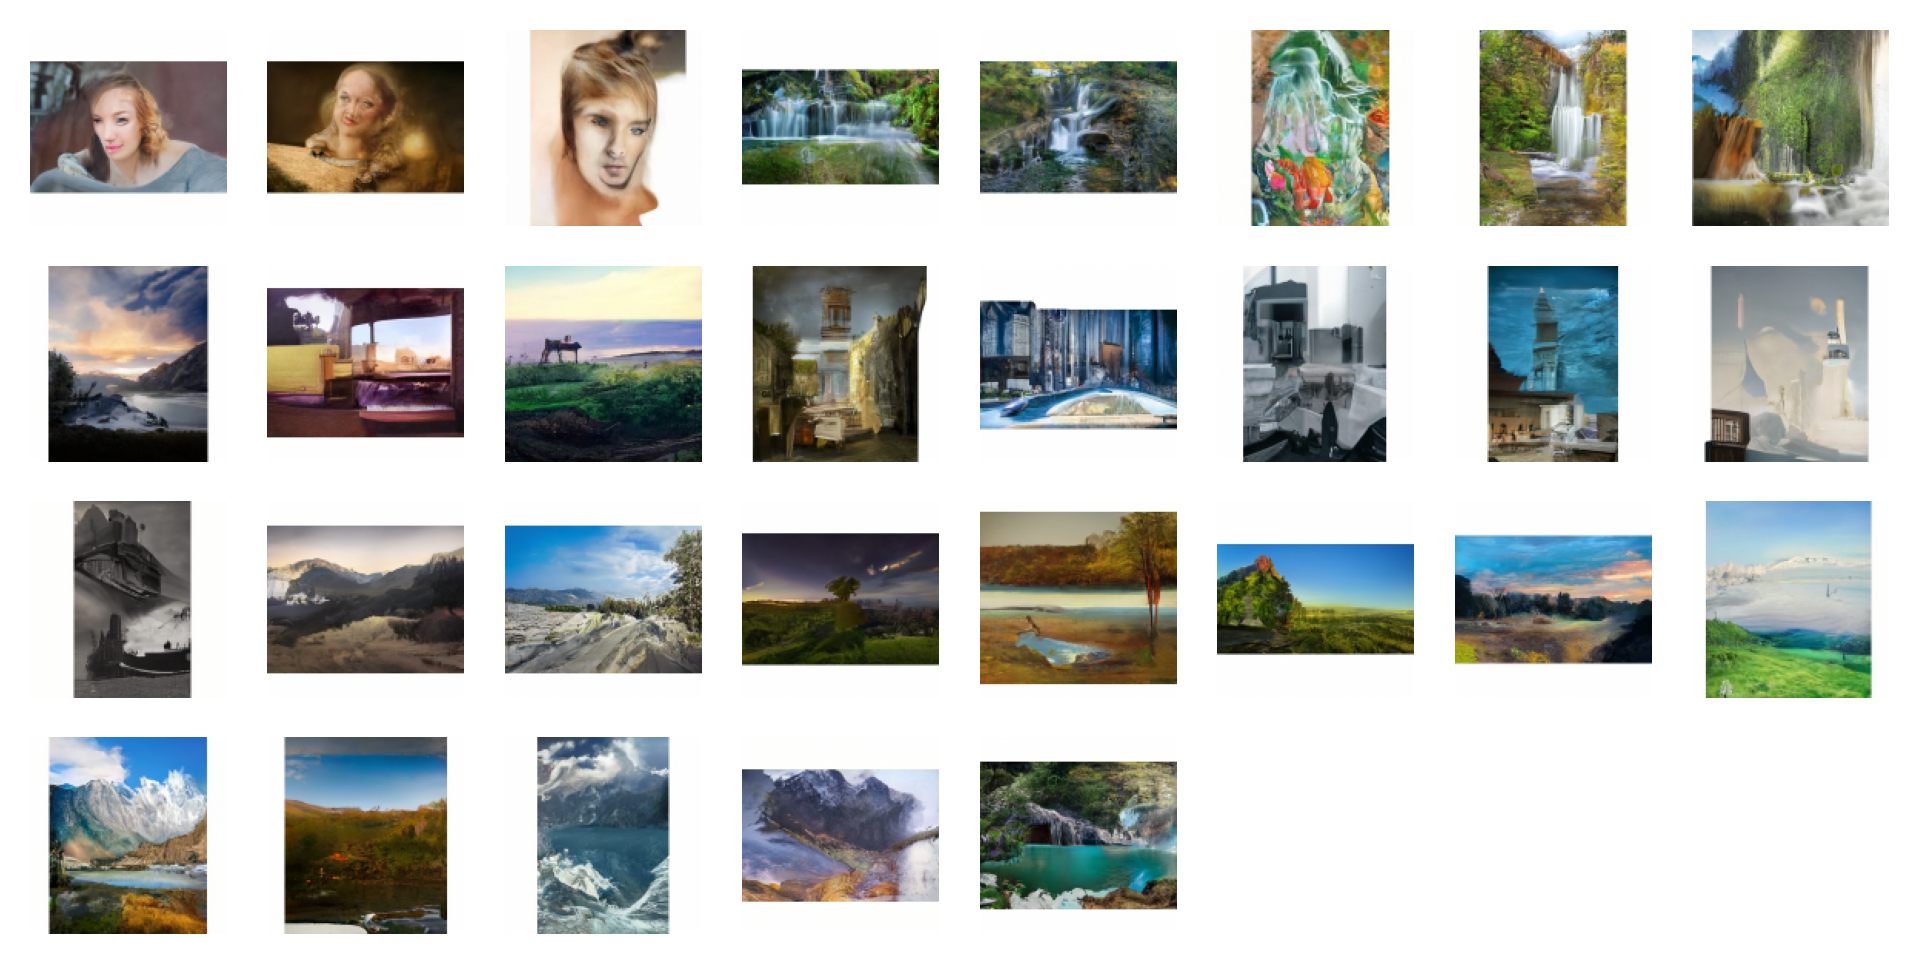

In [27]:

prompts = [
    "A photo of a beautiful young girl",
    "A photo of a beautiful young girl",
    "A photo of a beautiful young girl",
    "A beautiful waterfall",
    "A beautiful waterfall",
    "A beautiful waterfall",
    "A beautiful waterfall",
    "A beautiful waterfall",
    "a big house",
    "a big house",
    "a big house",
    "a big house",
    "a big house",
    "a big building",
    "a big building",
    "a big building",
    "a big building",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    ]
pooled_labels, labels_seq = encodePrompts(prompts, textEncoderModel, textTokenizer)

sampler = EulerAncestralSampler(trainer.model, trainer.get_state().ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform, guidance_scale=2, null_labels_seq=null_labels_full)
samples = sampler.generate_images(num_images=len(prompts), diffusion_steps=200, start_step=1000, end_step=0, priors=None, model_conditioning_inputs=(labels_seq,))
plotImages(samples, dpi=300)


In [30]:

prompts = [
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    ]
pooled_labels, labels_seq = encodePrompts(prompts, textEncoderModel, textTokenizer)

sampler = EulerAncestralSampler(trainer.model, trainer.get_state().ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform, guidance_scale=2, null_labels_seq=null_labels_full)
samples = sampler.generate_images(num_images=len(prompts), diffusion_steps=200, start_step=1000, end_step=0, priors=None, model_conditioning_inputs=(labels_seq,))
plotImages(samples, dpi=500)


Using classifier-free guidance


100%|██████████| 200/200 [00:38<00:00,  5.19it/s]


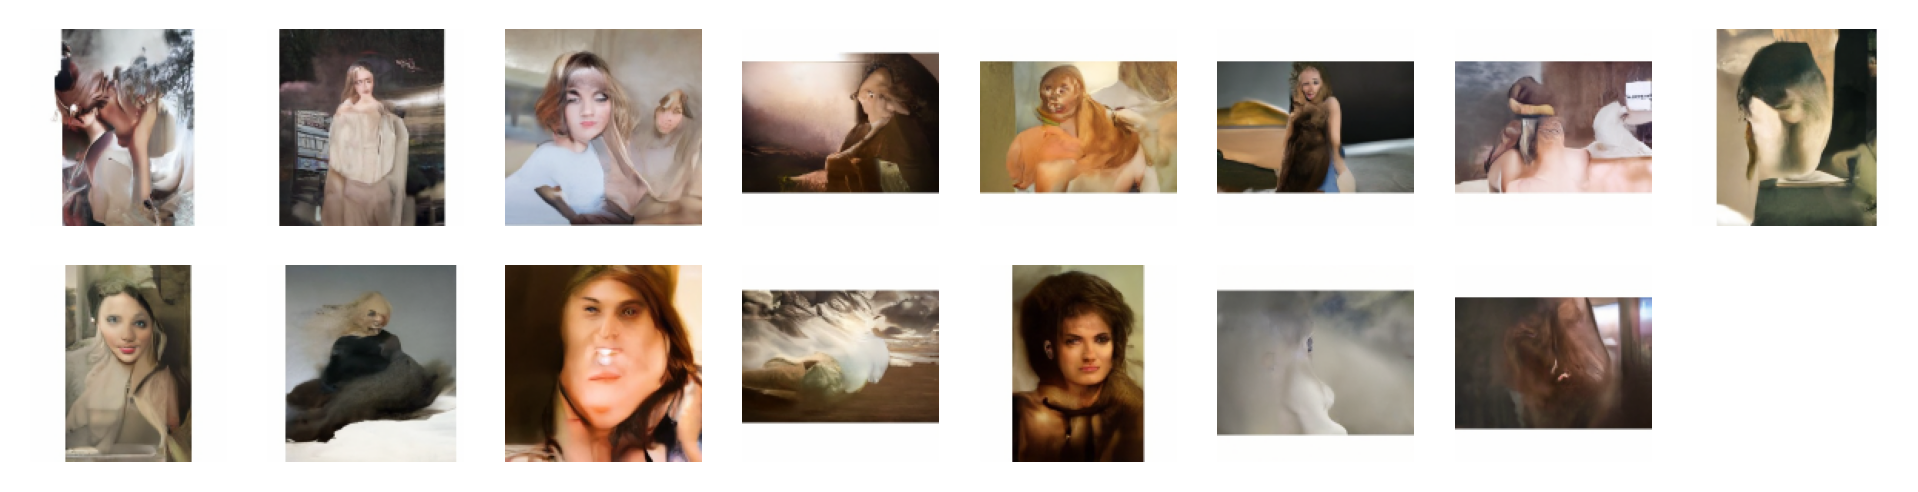

In [29]:

prompts = [
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    "A photo of a beautiful naked young girl standing",
    ]
pooled_labels, labels_seq = encodePrompts(prompts, textEncoderModel, textTokenizer)

sampler = EulerAncestralSampler(trainer.model, trainer.get_best_state().ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform, guidance_scale=2, null_labels_seq=null_labels_full)
samples = sampler.generate_images(num_images=len(prompts), diffusion_steps=200, start_step=1000, end_step=0, priors=None, model_conditioning_inputs=(labels_seq,))
plotImages(samples, dpi=300)
